# Import des librairies

In [11]:
%%time
import time
init_time = time.time()

import os
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import sklearn
import pickle


from matplotlib import pyplot as plt

import seaborn as sns

import string
import re

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score

print("Python version:", sys.version)
print("Version info.:", sys.version_info)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("skearn version:", sklearn.__version__)
print("re version:", re.__version__)
#print("nltk version:", nltk.__version__)
print("tensorflow version:", tf.__version__)
print("tensorflow_hub version:", hub.__version__)
print("tensorflow_text version:", text.__version__)

Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Version info.: sys.version_info(major=3, minor=11, micro=12, releaselevel='final', serial=0)
pandas version: 2.1.4
numpy version: 1.26.4
skearn version: 1.4.2
re version: 2.2.1
tensorflow version: 2.18.0
tensorflow_hub version: 0.16.1
tensorflow_text version: 2.18.1
CPU times: user 362 µs, sys: 0 ns, total: 362 µs
Wall time: 368 µs


# Chargement des données

In [12]:
path = "/content/drive/MyDrive/data/sentiments"
#path = "./data/sentiments"

In [13]:
tweets_df_count_vectorizer_1gram = np.load(os.path.join(path, "tweets_df_em_1gram.npy"), allow_pickle=True)
tweets_df_count_vectorizer_1gram

array(<1593071x695610 sparse matrix of type '<class 'numpy.int64'>'
	with 11079999 stored elements in Compressed Sparse Row format>,
      dtype=object)

In [14]:
tweets_df_count_vectorizer_1gram.item()[10].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [15]:
targets = np.load(os.path.join(path, "targets.npy"), allow_pickle=True)
targets

array([0, 0, 0, ..., 1, 1, 1])

In [16]:
%%time
tweets_df_count_vectorizer_1gram = np.load(os.path.join(path, "tweets_df_em_1gram.npy"), allow_pickle=True)
tweets_df_count_vectorizer_2gram = np.load(os.path.join(path, "tweets_df_em_2gram.npy"), allow_pickle=True)

tweets_df_tfidf_1gram = np.load(os.path.join(path, "tweets_df_tfidf_1gram.npy"), allow_pickle=True)

tweets_embeddings_bert = np.load(os.path.join(path, "embeddings_bert.npy"), allow_pickle=True)
tweets_embeddings_fasttext = pickle.load(open(os.path.join(path, "embeddings_fasttext.pkl"), "rb"))
tweets_embeddings_word2vec = pickle.load(open(os.path.join(path, "embeddings_word2vec.pkl"), "rb"))

CPU times: user 6.65 s, sys: 2.92 s, total: 9.57 s
Wall time: 16.9 s


In [17]:
print(tweets_df_count_vectorizer_1gram.item().shape)
print(tweets_df_count_vectorizer_2gram.item().shape)
print(tweets_df_tfidf_1gram.item().shape)
print(tweets_embeddings_bert.shape)

(1593071, 695610)
(1593071, 695643)
(1593071, 695610)
(10000, 768)


In [18]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import TruncatedSVD

# Matrice d'entrée (CSR sparse matrix)
X = tweets_df_count_vectorizer_1gram.item()  # ou .item() si stocké dans np.array
#svd = TruncatedSVD(n_components=, random_state=42)
#X = svd.fit_transform(X)
# Variable cible
y = targets  # adapte le nom ici

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Répartition dans y      :", pd.Series(y).value_counts(normalize=True))
print("Répartition dans y_train:", pd.Series(y_train).value_counts(normalize=True))
print("Répartition dans y_test :", pd.Series(y_test).value_counts(normalize=True))

Répartition dans y      : 1    0.500037
0    0.499963
Name: proportion, dtype: float64
Répartition dans y_train: 1    0.500038
0    0.499962
Name: proportion, dtype: float64
Répartition dans y_test : 1    0.500036
0    0.499964
Name: proportion, dtype: float64
CPU times: user 447 ms, sys: 11.1 ms, total: 458 ms
Wall time: 466 ms


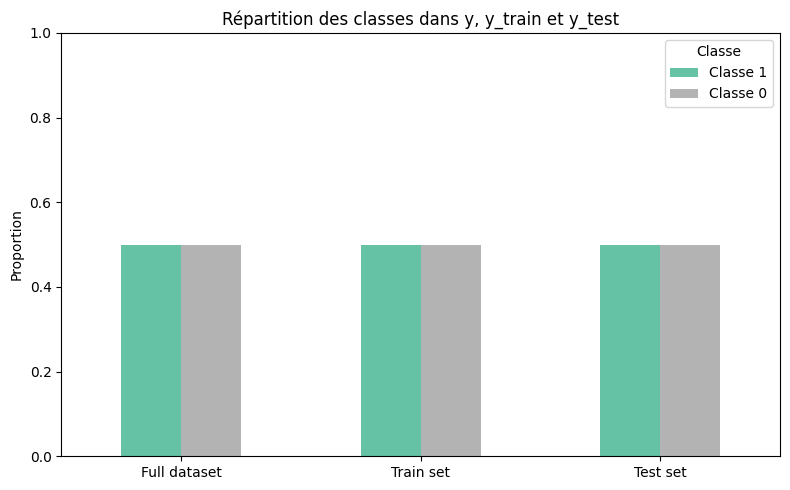

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Création des distributions
dist_df = pd.DataFrame({
    "Full dataset": pd.Series(y).value_counts(normalize=True),
    "Train set": pd.Series(y_train).value_counts(normalize=True),
    "Test set": pd.Series(y_test).value_counts(normalize=True)
}).T

# Optionnel : renommer les colonnes
dist_df.columns = ["Classe 1", "Classe 0"]

# Barplot
dist_df.plot(kind="bar", figsize=(8, 5), colormap="Set2")
plt.title("Répartition des classes dans y, y_train et y_test")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(title="Classe")
plt.tight_layout()
plt.show()

# Approche 1: Modéle sur mesure

- Logistic Regression
- Ridge Classifier
- Naive Bayes
- Light Gradient Boosting Machine
- Gradient Boosting Classifier
- linear discriminant analysis

In [20]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Ridge Classifier": RidgeClassifier(),
    #"Naive Bayes": MultinomialNB(),
    #"Gradient Boosting": GradientBoostingClassifier(),
    #"LightGBM": LGBMClassifier(),
    #"LDA": LDA()
}

In [21]:
def evaluate_models(x_train, x_test, y_train, y_test, models, cv=3, scoring="accuracy"):
    results = []

    for name, model in models.items():
      scores = cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring)
      y_pred = model.fit(x_train, y_train).predict(x_test)
      results.append({
          "Model": name,
          "train_mean_score": np.mean(scores),
          "test_score": model.score(x_test, y_test),
          "test_precision": precision_score(y_test, y_pred),
          "test_recall": recall_score(y_test, y_pred),
          "test_f1": f1_score(y_test, y_pred),
          "test_auc": roc_auc_score(y_test, y_pred),
          "test_mse": mean_squared_error(y_test, y_pred)
      })

    return pd.DataFrame(results)

## | CountVectorizer

In [ ]:
%%time
r_df = evaluate_models(X_train, X_test, y_train, y_test, models)

## | Tf-idf

In [ ]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tweets_df_tfidf_1gram.item(), y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
%%time
tfidf = evaluate_models(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, models)

In [ ]:
tfidf

## | Word2Vec

In [ ]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(tweets_embeddings_word2vec, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
%%time
w2v_df = evaluate_models(X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v, models)

In [ ]:
w2v_df

## | FastText

In [ ]:
X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(tweets_embeddings_fasttext, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
%%time
ft_df = evaluate_models(X_train_ft, X_test_ft, y_train_ft, y_test_ft, models)

In [ ]:
display(ft_df)

# Approche 2: Modèle sur mesure avancé (Reseau de Neurone)